In [26]:
import os
import cv2
import keras
import numpy as np
import contextlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import gradio as gr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from mtcnn import MTCNN
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras.applications import EfficientNetV2S
from keras.layers import Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

c:\Users\vedha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define preprocessing function based on the model
# Making it global since it is used many times
global preprocess_input
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Gender Prediction with mask

## Model Training

In [ ]:
def train_model_with_efficientnetV2S(use_pre_trained_weights, image_size=(260, 260), batch_size=32, epochs=10):
    
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2  
    )

    
    train_generator = train_datagen.flow_from_directory(
        'face_only_images/train',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',  
        subset='training'     
    )

    validation_generator = train_datagen.flow_from_directory(
        'face_only_images/train',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'   
    )

    
    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(260,260, 3))

    if use_pre_trained_weights:
        
        for layer in base_model.layers:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = True

    
    model = base_model.output

    # Adding Additional layers
    model=tf.keras.layers.GlobalAveragePooling2D()(model)
    model = Flatten(name="flatten")(model)
    model = Dense(128, activation="relu")(model)
    model = Dropout(0.5)(model)
    model = Dense(1, activation="sigmoid")(model)
    model = Model(inputs=base_model.input, outputs=model)

    
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).repeat()

    validation_dataset = tf.data.Dataset.from_generator(
        lambda: validation_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).repeat()

    steps_per_epoch = train_generator.samples // batch_size + 1
    validation_steps = validation_generator.samples // batch_size + 1

    
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_dataset,
        validation_steps=validation_steps,
        epochs=epochs
    )

    print("Training Accuracy:", history.history['accuracy'][-1])
    print("Validation Accuracy:", history.history['val_accuracy'][-1])

    return model

In [ ]:
trained_moded_after_training_weights = train_model_with_efficientnetV2S(False)

Found 1785 images belonging to 2 classes.
Found 445 images belonging to 2 classes.
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1605s 27s/step - accuracy: 0.7336 - loss: 0.5419 - val_accuracy: 0.8360 - val_loss: 0.3961
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 749s 13s/step - accuracy: 0.8566 - loss: 0.3656 - val_accuracy: 0.8944 - val_loss: 0.2686
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 749s 13s/step - accuracy: 0.8975 - loss: 0.2779 - val_accuracy: 0.8697 - val_loss: 0.2967
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 727s 13s/step - accuracy: 0.9011 - loss: 0.2578 - val_accuracy: 0.8360 - val_loss: 0.4364
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 719s 13s/step - accuracy: 0.9011 - loss: 0.2527 - val_accuracy: 0.8809 - val_loss: 0.3148
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 702s 13s/step - accuracy: 0.9045 - loss: 0.2366 - val_accuracy: 0.8831 - val_loss: 0.2782
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 884s 16s/step - accuracy: 0.9167 - loss: 0.2201 - val_accuracy: 0.8854 - val_loss: 0.2826
Epoch 8/10
56/56 ━━━

## Model Testing and plotting confusion matrix

In [3]:
def plot_confusion_matrix(model, test_path, image_size=(260, 260), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    test_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = np.round(predictions).astype(int).flatten()
    cm = confusion_matrix(test_labels, predicted_labels)
    accuracy = np.trace(cm) / np.sum(cm)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Saving the model

In [ ]:
trained_moded_after_training_weights.save('models/EfficientV2S_trained.keras')

In [10]:
gender_predict_with_mask_model = load_model('EfficientNetV2S_Models/gender_prediction_with_mask.keras')

### Plotting the confustion matrix

Found 565 images belonging to 2 classes.


c:\Users\vedha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step
Test Accuracy: 90.97%


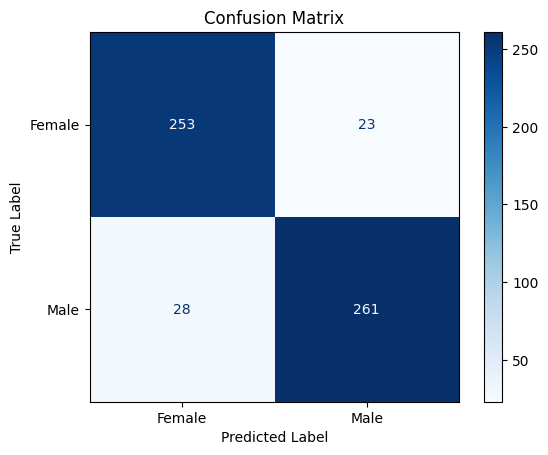

In [10]:
test_path = 'face_only_images/test'
plot_confusion_matrix(gender_predict_with_mask_model, test_path)

## Face Detection in a Image

In [14]:
detector = MTCNN()

def detect_and_crop_face(image_path):

    image = cv2.imread(image_path)
    
    # Resizing the image so that it takes less time to detect and crop
    image = cv2.resize(image, (520, 520))
    
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    faces = detector.detect_faces(image_rgb)

    if faces:
        # COnsidering only the first face
        face = faces[0]
        x, y, width, height = face['box']

        cropped_face = image_rgb[y:y+height, x:x+width]
        cropped_face = cv2.resize(cropped_face, (260, 260))
        # Changing the file itself
        cropped_image_path = image_path

        cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))
        return 1, image_path
    else:
        print("There are no faces in the image")
        return -1, None

# Function to train the next two models

In [4]:
def train_model_2(train_path, validation_path, image_size=(260, 260), batch_size=32, epochs=10):
    
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary', 
    )

    validation_generator = train_datagen.flow_from_directory(
        validation_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',  
    )

    
    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(260,260, 3))

    for layer in base_model.layers:
        layer.trainable = True

    model = base_model.output
    
    model=tf.keras.layers.GlobalAveragePooling2D()(model)
    model = Flatten(name="flatten")(model)
    model = Dense(128, activation="relu")(model)
    model = Dropout(0.5)(model)
    model = Dense(1, activation="sigmoid")(model)
    model = Model(inputs=base_model.input, outputs=model)

    
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).repeat()

    validation_dataset = tf.data.Dataset.from_generator(
        lambda: validation_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).repeat()

    
    steps_per_epoch = train_generator.samples // batch_size + 1
    validation_steps = validation_generator.samples // batch_size + 1

    
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_dataset,
        validation_steps=validation_steps,
        epochs=epochs
    )

    
    print("Training Accuracy:", history.history['accuracy'][-1])
    print("Validation Accuracy:", history.history['val_accuracy'][-1])

    return model

## Face Mask Detection

### Training the model using the above function

In [5]:
train_path = 'Face-mask-detection-final/images/train'
validation_path = 'Face-mask-detection-final/images/validation'
test_path = 'Face-mask-detection-final/images/test'
trained_model_for_face_mask_detection = train_model_2(train_path, validation_path)

Found 1932 images belonging to 2 classes.
Found 396 images belonging to 2 classes.
Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 787s 12s/step - accuracy: 0.9333 - loss: 0.1579 - val_accuracy: 0.9823 - val_loss: 0.1035
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 701s 11s/step - accuracy: 0.9818 - loss: 0.0587 - val_accuracy: 0.9899 - val_loss: 0.0472
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 673s 11s/step - accuracy: 0.9917 - loss: 0.0210 - val_accuracy: 0.9823 - val_loss: 0.0478
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 706s 12s/step - accuracy: 0.9909 - loss: 0.0312 - val_accuracy: 0.9949 - val_loss: 0.0411
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 698s 11s/step - accuracy: 0.9955 - loss: 0.0159 - val_accuracy: 0.9924 - val_loss: 0.0514
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 697s 11s/step - accuracy: 0.9976 - loss: 0.0164 - val_accuracy: 0.9924 - val_loss: 0.0617
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 697s 11s/step - accuracy: 0.9977 - loss: 0.0097 - val_accuracy: 0.9924 - val_loss: 0.0669
Epoch 8/10
61/61 ━━━━

### Saving the model

In [6]:
trained_model_for_face_mask_detection.save('EfficientNetV2S_Models/face_mask_detection_model_final.keras')

In [7]:
trained_model_for_face_mask_detection = load_model('EfficientNetV2S_Models/face_mask_detection_model_final.keras')

### Model Testing and confusion matrix

Found 459 images belonging to 2 classes.


c:\Users\vedha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
Test Accuracy: 96.73%


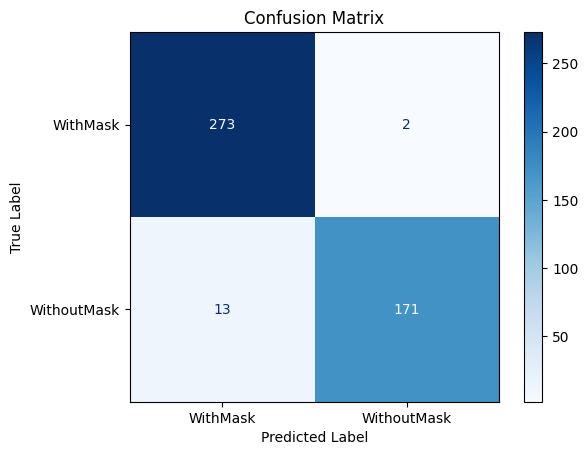

In [8]:
def plot_confusion_matrix(model, test_path, image_size=(260, 260), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    test_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = np.round(predictions).astype(int).flatten()
    cm = confusion_matrix(test_labels, predicted_labels)
    accuracy = np.trace(cm) / np.sum(cm)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


test_path = 'Face-mask-detection/archive/Face Mask Dataset/Test'
plot_confusion_matrix(trained_model_for_face_mask_detection, test_path)


# Gender prediction without mask

## Model Training

In [ ]:
train_path = 'Gender_prediction/archive/Training'
validation_path = 'Gender_prediction/archive/Validation'
trained_model_for_gender_prediction_without_mask = train_model_2(train_path, validation_path)

Found 2165 images belonging to 2 classes.
Found 414 images belonging to 2 classes.
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1393s 17s/step - accuracy: 0.7976 - loss: 0.4372 - val_accuracy: 0.9179 - val_loss: 0.2638
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 985s 14s/step - accuracy: 0.9310 - loss: 0.2041 - val_accuracy: 0.9565 - val_loss: 0.1543
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 817s 12s/step - accuracy: 0.9543 - loss: 0.1288 - val_accuracy: 0.9444 - val_loss: 0.1591
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 862s 13s/step - accuracy: 0.9615 - loss: 0.1009 - val_accuracy: 0.9493 - val_loss: 0.1586
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 897s 13s/step - accuracy: 0.9601 - loss: 0.0982 - val_accuracy: 0.9589 - val_loss: 0.1305
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 858s 13s/step - accuracy: 0.9746 - loss: 0.0714 - val_accuracy: 0.9541 - val_loss: 0.1914
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 839s 12s/step - accuracy: 0.9604 - loss: 0.1055 - val_accuracy: 0.9589 - val_loss: 0.1981
Epoch 8/10
68/68 ━━━

## Model Testing and Confusion Matrix

Found 408 images belonging to 2 classes.


c:\Users\vedha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
Test Accuracy: 95.59%


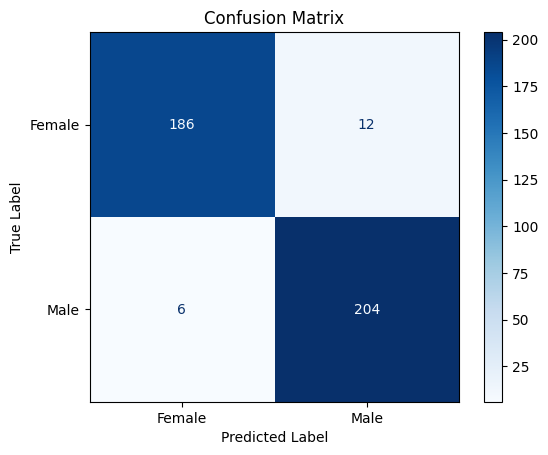

In [ ]:
test_path = 'Gender_prediction/archive/Test'
plot_confusion_matrix(trained_model_for_gender_prediction_without_mask, test_path)

### Saving the model

In [ ]:
trained_model_for_gender_prediction_without_mask.save('EfficientNetV2S_Models/gender_prediction.keras')

In [9]:
trained_model_for_gender_prediction_without_mask = load_model('EfficientNetV2S_Models/gender_prediction.keras')

# Implementation on a single image

### Function to predict the result of the model.

In [11]:
def predict(model, image_path, to_predict, image_size=(260, 260)):
    
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict gender
    prediction = model.predict(img_array)
    probability = prediction[0][0] * 100
    
    result = ""
    if to_predict == 'Gender':
        if probability > 50:
            result = "Male"
            print(f"{result} ({probability:.2f}%)")
        else: 
            result = "Female"
            print(f"{result} ({100 - probability:.2f}%)")
    elif to_predict == 'Mask':
        if probability > 50:
            result = "WithoutMask"
            print(f"{result} ({probability:.2f}%)")
        else: 
            result = "WithMask"
            print(f"{result} ({100 - probability:.2f}%)")
    
    return result


### Implementaion

In [15]:
def predict_single_image(test_image_path):
    x, cropped_image_path = detect_and_crop_face(test_image_path)
    image = mpimg.imread(test_image_path)
    plt.imshow(image)
    plt.axis('off') 
    plt.show()
    # If there is a face in the image
    if x == 1: 
        mask = predict(trained_model_for_face_mask_detection, cropped_image_path, "Mask")
        if mask == "WithMask":
            gender = predict(gender_predict_with_mask_model, cropped_image_path, "Gender")
        else:
            gender = predict(trained_model_for_gender_prediction_without_mask, cropped_image_path, "Gender")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


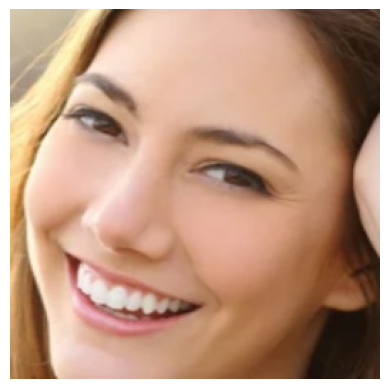

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
WithoutMask (99.98%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Female (100.00%)


In [16]:
test_path = 'female_image_without_mask.jpg'
predict_single_image(test_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


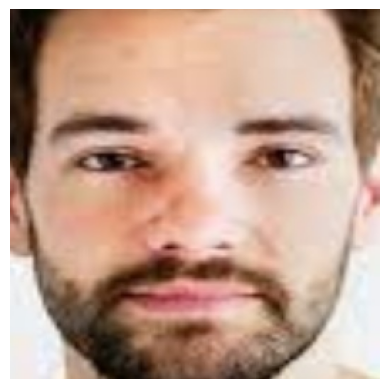

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
WithoutMask (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Male (100.00%)


In [17]:
test_path = 'male_image_without_mask.jpg'
predict_single_image(test_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


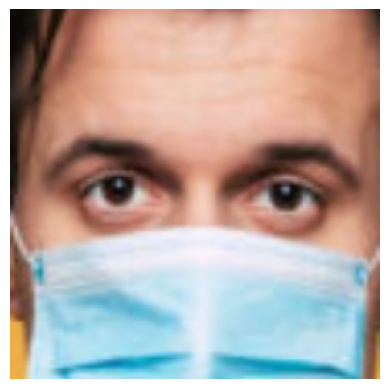

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
WithMask (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Male (74.17%)


In [18]:
test_path = 'male_image_with_mask.jpg'
predict_single_image(test_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


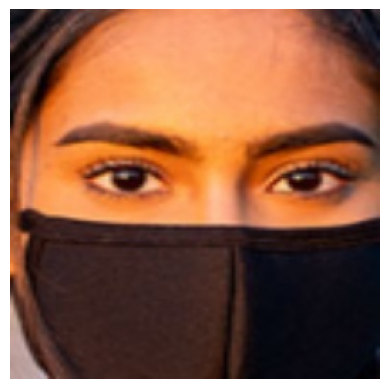

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
WithMask (99.96%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Female (99.99%)


In [19]:
test_path = 'female_image_with_mask.jpg'
predict_single_image(test_path)